## Overview

The purpose of this notebook is to analyze the dataset of A Thaliana, before applying sequence clustering.

The AAC is calculated und checked for outliers, then a simple ML model is trained to estimate performance

The performance of PSSM and PAAC should correlate with that of AAC. 

This analysis will then be applied to other organisms.

The plots are generated again in notebook 2, after removing the outliers.

## Imports

In [3]:
from subpred.transporter_dataset import create_dataset
from subpred.compositions import calculate_aac, calculate_paac
from subpred.plots import (
    labeled_clustermap,
    get_clusters,
    corr_heatmap,
    plot_full_test,
    pca_plot_2d,
    pca_plot_3d,
)
from subpred.eval import quick_test, models_quick_compare, full_test


## Creating the dataset

In [4]:
df = create_dataset(
    keywords_substrate_filter = ["Amino-acid transport","Sugar transport"],
    keywords_component_filter = ["Transmembrane"],
    keywords_transport_filter = ["Transport"],
    input_file = "../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate = "keep",
    verbose = True,
    tax_ids_filter = [3702],
    output_log = "../logs/athaliana_amino_sugar_dataset.log",
)

In [5]:
df.head()

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
Q9SFG0,Sugar transport,Membrane;Transmembrane,Symport;Transport,STP6 At3g05960 F2O10.8,Sugar transport protein 6 (Hexose transporter 6),2.A.1.1.56,2.A,3702,MAVVVSNANAPAFEAKMTVYVFICVMIAAVGGLIFGYDIGISGGVS...
Q9ZVK6,Sugar transport,Cell membrane;Membrane;Transmembrane,Symport;Transport,SUC8 At2g14670 T6B13.9,Sucrose transport protein SUC8 (Sucrose permea...,NaN,0.0,3702,MSDLQAKNDVVAVDRQSSSSLADLDGPSPLRKMISVASIAAGIQFG...
Q84WN3,Sugar transport,Membrane;Transmembrane,Transport,SWEET17 At4g15920 dl4000c FCAALL.237,Bidirectional sugar transporter SWEET17 (AtSWE...,NaN,0.0,3702,MAEASFYIGVIGNVISVLVFLSPVETFWKIVKRRSTEEYKSLPYIC...
O04249,Sugar transport,Cell membrane;Membrane;Transmembrane,Symport;Transport,STP7 At4g02050 AGAA.1 T10M13.6,Sugar transport protein 7 (Hexose transporter 7),NaN,0.0,3702,MAGGSFGPTGVAKERAEQYQGKVTSYVIIACLVAAIGGSIFGYDIG...
Q56ZZ7,Sugar transport,Membrane;Plastid inner membrane;Transmembrane,Transport,At5g16150 T21H19.70,Plastidic glucose transporter 4 (AtpGlcT),2.A.1.1.102,2.A,3702,MQSSTYAVKGNAAFAFQRRTFSSDRSTTSTGIRFAGYKSLATTGPL...


### Stats

Imbalanced dataset, but enough samples per class. No transporters with two known substrates.

In [6]:
df.keywords_transport.value_counts()

Sugar transport         118
Amino-acid transport     54
Name: keywords_transport, dtype: int64

Two proteins are in MT membrane, are they beta barrel proteins?

In [7]:
df.keywords_location.value_counts()

Membrane;Transmembrane                                        108
Cell membrane;Membrane;Transmembrane                           52
Endoplasmic reticulum;Membrane;Transmembrane                    7
Membrane;Mitochondrion;Transmembrane                            2
Membrane;Plastid inner membrane;Transmembrane                   1
Cell membrane;Endoplasmic reticulum;Membrane;Transmembrane      1
Cell membrane;Membrane;Nucleus;Transmembrane                    1
Name: keywords_location, dtype: int64

No, both are helix bundles

In [8]:
df[df.keywords_location.str.contains("Mito")]

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
Q9ZU50,Amino-acid transport,Membrane;Mitochondrion;Transmembrane,Transport,BAT1 GABP At2g01170 F10A8.5,Amino-acid permease BAT1 (Bidirectional amino ...,NaN,0.0,3702,MGLGGDQSFVPVMDSGQVRLKELGYKQELKRDLSVFSNFAISFSII...
Q8GYB4,Amino-acid transport,Membrane;Mitochondrion;Transmembrane,Transport,CAT3 At5g36940 MLF18.60,"Cationic amino acid transporter 3, mitochondrial",NaN,0.0,3702,MGCLRSLVRRKQFDSSNGKAETHHHHQQLAKALTFPHLIAIGVGST...


Nucleus transporter also looks okay, helix bundle and TCDB 2A

In [9]:
df[df.keywords_location.str.contains("Nucleus")]

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
Q39134,Amino-acid transport,Cell membrane;Membrane;Nucleus;Transmembrane,Symport;Transport,AAP3 At1g77380 F2P24.9,Amino acid permease 3 (Amino acid transporter ...,2.A.18.2.3,2.A,3702,MVQNHQTVLAVDMPQTGGSKYLDDDGKNKRTGSVWTASAHIITAVI...


Interestingly, many transporters are still annotated with Symport or Antiport, even though only one substrate is known.

In [10]:
df.keywords_transport_related.value_counts()

Transport             114
Symport;Transport      39
Antiport;Transport     19
Name: keywords_transport_related, dtype: int64

The Antiporters all seem to be nucleotide-sugar transporters. They are all annotated as sugar transporters in Uniprot, and nucleotide-sugar transmembrane transporter activity
in GO. The latter is a child of carbohydrate derivative transport. We'll just keep them in the dataset, and see if they influence model fit in a negative way later.

In [11]:
df[df.keywords_transport_related.str.contains("Antiport")]

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
Q9SRE4,Sugar transport,Membrane;Transmembrane,Antiport;Transport,URGT1 UDP-GALT2 At1g76670 F28O16.4,UDP-rhamnose/UDP-galactose transporter 1 (UDP-...,2.A.7.9.12,2.A,3702,MEKPESEKKSAVSDVGAWAMNVISSVGIIMANKQLMSSSGFGFGFA...
Q6NM25,Sugar transport,Membrane;Transmembrane,Antiport;Transport,UTR5 At3g46180 F12M12.150,UDP-galactose/UDP-glucose transporter 5 (AtUTr5),2.A.7.11.7,2.A,3702,MAEPDSVNEAKEKKKKLWKAVFAISGIMLTLVIYGLLQEKIMRVPY...
Q9LPU2,Sugar transport,Membrane;Transmembrane,Antiport;Transport,URGT2 At1g21070 T22I11.10,UDP-rhamnose/UDP-galactose transporter 2 (UDP-...,2.A.7.9.13,2.A,3702,MEKAENEKKPSAVSDVGAWAMNVTSSVGIIMANKQLMSSSGFGFSF...
O64503,Sugar transport,Endoplasmic reticulum;Membrane;Transmembrane,Antiport;Transport,UTR1 At2g02810 T20F6.5,UDP-galactose/UDP-glucose transporter 1 (At-UD...,2.A.7.11.4,2.A,3702,MEVHGSGFRRILLLALCISGIWSAYIYQGVLQETLSTKRFGPDEKR...
Q9LDX3,Sugar transport,Membrane;Transmembrane,Antiport;Transport,UTR4 At1g12600 F5O11.33 T12C24.13,UDP-galactose/UDP-glucose transporter 4 (AtUTr4),NaN,0.0,3702,MKTNSEEQMIKLFGIPLSDKPRWQQFLICSSGFFFGYLVNGICEEY...
Q29Q28,Sugar transport,Membrane;Transmembrane,Antiport;Transport,UTR2 At4g23010 F7H19.200,UDP-galactose/UDP-glucose transporter 2 (AtUTr2),NaN,0.0,3702,MKEEQTRSLFGISLSDKPTWQQFLICTSGFFFGYLVNGVCEEYVYN...
Q6NMB6,Sugar transport,Membrane;Transmembrane,Antiport;Transport,UTR5B At5g59740 MTH12.11,UDP-galactose/UDP-glucose transporter 5B (AtUT...,NaN,0.0,3702,MAEPELVNGGVKENKLWKGVFAVSGIMSTLVIYGVLQEKIMRVPYG...
Q9M9S6,Sugar transport,Endoplasmic reticulum;Membrane;Transmembrane,Antiport;Transport,UTR3 MSS4 At1g14360 F14L17.13,UDP-galactose/UDP-glucose transporter 3 (AtUTr3),NaN,0.0,3702,MESHGSGLRRVLLLSFCVAGIWAAYIYQGILQETLSTKKFGEDGKR...
Q84L08,Sugar transport,Membrane;Transmembrane,Antiport;Transport,GFT1 GONST4 At5g19980 F28I16.130,GDP-fucose transporter 1 (GDP-mannose transpor...,NaN,0.0,3702,MSSSRFDSNKQLTTSSLVIGYALCSSLLAVINKLAITYFNYPGLLT...


The Symporters all have Protons as their second substrate, that seems to be part of their transport mechanism. 

In [12]:
df[df.keywords_transport_related.str.contains("Symport")]

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
Q9SFG0,Sugar transport,Membrane;Transmembrane,Symport;Transport,STP6 At3g05960 F2O10.8,Sugar transport protein 6 (Hexose transporter 6),2.A.1.1.56,2.A,3702,MAVVVSNANAPAFEAKMTVYVFICVMIAAVGGLIFGYDIGISGGVS...
Q9ZVK6,Sugar transport,Cell membrane;Membrane;Transmembrane,Symport;Transport,SUC8 At2g14670 T6B13.9,Sucrose transport protein SUC8 (Sucrose permea...,NaN,0.0,3702,MSDLQAKNDVVAVDRQSSSSLADLDGPSPLRKMISVASIAAGIQFG...
O04249,Sugar transport,Cell membrane;Membrane;Transmembrane,Symport;Transport,STP7 At4g02050 AGAA.1 T10M13.6,Sugar transport protein 7 (Hexose transporter 7),NaN,0.0,3702,MAGGSFGPTGVAKERAEQYQGKVTSYVIIACLVAAIGGSIFGYDIG...
Q9FMX3,Sugar transport,Cell membrane;Membrane;Transmembrane,Symport;Transport,STP11 At5g23270 MKD15.13,Sugar transport protein 11 (Hexose transporter...,2.A.1.1.61,2.A,3702,MAGGAFIDESGHGGDYEGRVTAFVMITCIVAAMGGLLFGYDIGISG...
Q8L7R8,Sugar transport,Membrane;Transmembrane,Symport;Transport,STP3 At5g61520 K11J9_40,Sugar transport protein 3 (Hexose transporter 3),NaN,0.0,3702,MVAEEARKEAMAKSVSGGKITYFVVASCVMAAMGGVIFGYDIGVSG...
Q9LT15,Sugar transport,Membrane;Transmembrane,Symport;Transport,STP10 At3g19940 MPN9.19,Sugar transport protein 10 (Hexose transporter...,2.A.1.1.124,2.A,3702,MAGGAFVSEGGGGGRSYEGGVTAFVIMTCIVAAMGGLLFGYDLGIS...
Q39232,Sugar transport,Membrane;Transmembrane,Symport;Transport,SUC1 At1g71880 F17M19.3,Sucrose transport protein SUC1 (Sucrose permea...,2.A.2.4.1,2.A,3702,MGAYETEKPTKDAAALETQSPEDFDQPSPLRKIISVASIAAGVQFG...
O80605,Sugar transport,Cell membrane;Membrane;Transmembrane,Symport;Transport,SUC3 SUT2 At2g02860 T17M13.3,Sucrose transport protein SUC3 (Sucrose permea...,2.A.2.4.3,2.A,3702,MSDSVSISVPYRNLRKEIELETVTKHRQNESGSSSFSESASPSNHS...
Q93Y91,Sugar transport,Membrane;Transmembrane,Symport;Transport,STP5 At1g34580 F12K21.8,Sugar transport protein 5 (Hexose transporter 5),NaN,0.0,3702,MAGGGLALDVSSAGNIDAKITAAVVMSCIVAASCGLIFGYDIGISG...


#### TCDB

There is one protein classified as a channel, and most proteins have unknown TCDB class. The TCDB class of the unknown proteins will show later, when we will cluster the proteins according to their AAC. Different structure, such as beta barrel or single-pass, usually least to vastly different AAC, so we will find them. 

In [13]:
df.tcdb_class.value_counts()

0.0    114
2.A     57
1.A      1
Name: tcdb_class, dtype: int64

This is the channel. It seems to belong to the GDU family

In [14]:
df[df.tcdb_class.str.startswith("1")]

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
O81775,Amino-acid transport,Cell membrane;Membrane;Transmembrane,Transport,GDU1 At4g31730 F28M20.80,Protein GLUTAMINE DUMPER 1,1.A.41.2.2,1.A,3702,MRPLSVQSKFEDVATSTSVNHHGVTPQSPWHSPVPYLFGGLAAMLG...


There are seven GDU proteins in the dataset. According to Uniprot, they are all single-pass membrane proteins. According to literature, they do not form a transport complex.

In [15]:
df[df.gene_names.str.contains("GDU")]

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
O81775,Amino-acid transport,Cell membrane;Membrane;Transmembrane,Transport,GDU1 At4g31730 F28M20.80,Protein GLUTAMINE DUMPER 1,1.A.41.2.2,1.A,3702,MRPLSVQSKFEDVATSTSVNHHGVTPQSPWHSPVPYLFGGLAAMLG...
Q9SW07,Amino-acid transport,Membrane;Transmembrane,Transport,GDU2 At4g25760 F14M19.40,Protein GLUTAMINE DUMPER 2,NaN,0.0,3702,MQTMEGRQYNYQDSINASSSMVVPHSPWHSPVPYLFGGLAAMLALI...
Q9FHH5,Amino-acid transport,Membrane;Transmembrane,Transport,GDU3 LBS1 At5g57685 MRI1.4,Protein GLUTAMINE DUMPER 3 (Protein LESS SUSCE...,NaN,0.0,3702,MEGRQYYPPRENVEGNRTTMGGGPHSPWHSPVPYLFGGLAAMLGLI...
Q8S8A0,Amino-acid transport,Membrane;Transmembrane,Transport,GDU4 At2g24762 F27A10.11,Protein GLUTAMINE DUMPER 4,NaN,0.0,3702,MRPLSIKPTSLDVARHATSVESFGNHRPPISPWHSPVPYLFGGLAA...
Q3E965,Amino-acid transport,Membrane;Transmembrane,Transport,GDU5 At5g24920 F6A4.130,Protein GLUTAMINE DUMPER 5,NaN,0.0,3702,MRQFPSIRGNINEKMMTTMVESQTRSPWRTPVPYLFGGLAAMLGLI...
Q3EAV6,Amino-acid transport,Membrane;Transmembrane,Transport,GDU6 At3g30725 T4A2.7,Protein GLUTAMINE DUMPER 6,NaN,0.0,3702,MRPTPKVEIWKSPVPYLFGGLFLLVLLIALALLSLVCTHQKPSSSS...
Q3E8L0,Amino-acid transport,Membrane;Transmembrane,Transport,GDU7 At5g38770 MKD10.70,Protein GLUTAMINE DUMPER 7,NaN,0.0,3702,MSLHRDSMVPVNSRLENMDSPILSKICAWGVMLGLFALSLFAMAYA...


## Feature generation

In [16]:
labels = df.keywords_transport.rename("label").copy()
df_aac = calculate_aac(sequences=df.sequence)
df_paac = calculate_paac(sequences=df.sequence)

The 20 features can be arranged into two clusters. The right one corresponds to hydrophobic residues found in helices, the typical substrate-specificity amino acids are occur more rarely, and can be seen on the left. 

The samples are not clearly separatable into substrates through the ward clustering. Could point to a more complex model, that need many or most of the feature dimensions to separate the classes.

({'Amino-acid transport': 'cyan', 'Sugar transport': 'magenta'},
 <seaborn.matrix.ClusterGrid at 0x7f10d21a1d30>)

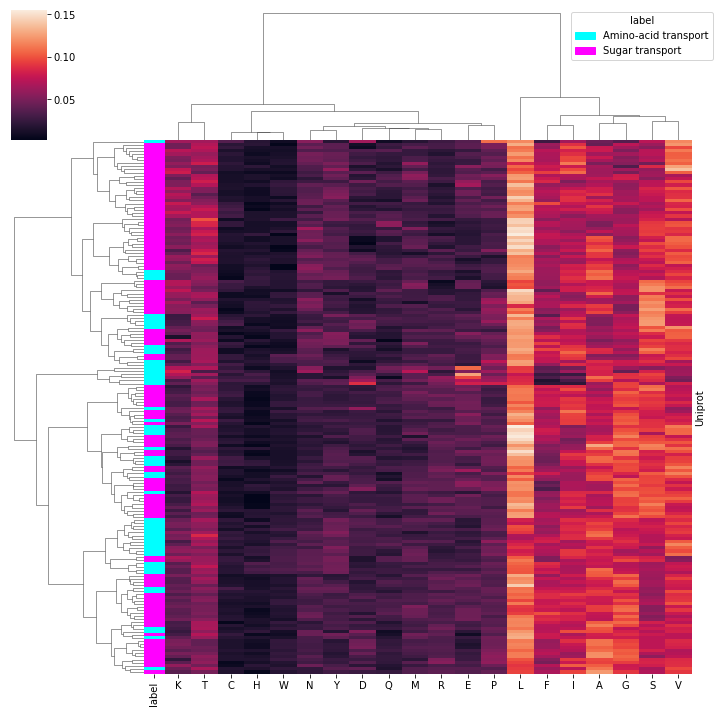

In [17]:
labeled_clustermap(df_aac, labels, xlabels="auto")

Here, we can see a small set of proteins with a vastly different AAC.

({'Amino-acid transport': 'cyan', 'Sugar transport': 'magenta'},
 <seaborn.matrix.ClusterGrid at 0x7f10d21ae160>)

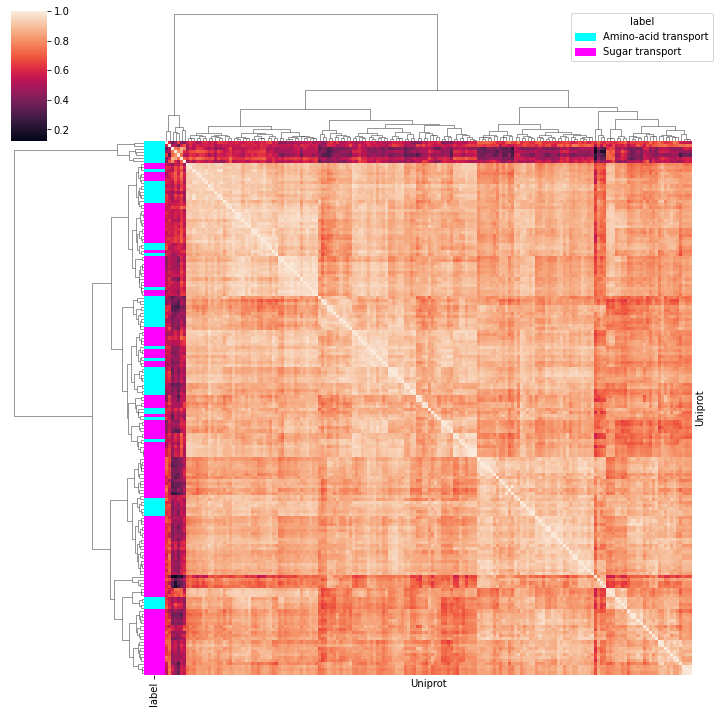

In [18]:
labeled_clustermap(df_aac.T.corr(), labels)

As it turns out, these are the GDU proteins again.

In [19]:
clusters = get_clusters(df_aac, n_clusters=3)
df.loc[clusters[2]]

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
O81775,Amino-acid transport,Cell membrane;Membrane;Transmembrane,Transport,GDU1 At4g31730 F28M20.80,Protein GLUTAMINE DUMPER 1,1.A.41.2.2,1.A,3702,MRPLSVQSKFEDVATSTSVNHHGVTPQSPWHSPVPYLFGGLAAMLG...
Q9SW07,Amino-acid transport,Membrane;Transmembrane,Transport,GDU2 At4g25760 F14M19.40,Protein GLUTAMINE DUMPER 2,NaN,0.0,3702,MQTMEGRQYNYQDSINASSSMVVPHSPWHSPVPYLFGGLAAMLALI...
Q9FHH5,Amino-acid transport,Membrane;Transmembrane,Transport,GDU3 LBS1 At5g57685 MRI1.4,Protein GLUTAMINE DUMPER 3 (Protein LESS SUSCE...,NaN,0.0,3702,MEGRQYYPPRENVEGNRTTMGGGPHSPWHSPVPYLFGGLAAMLGLI...
Q8S8A0,Amino-acid transport,Membrane;Transmembrane,Transport,GDU4 At2g24762 F27A10.11,Protein GLUTAMINE DUMPER 4,NaN,0.0,3702,MRPLSIKPTSLDVARHATSVESFGNHRPPISPWHSPVPYLFGGLAA...
Q3E965,Amino-acid transport,Membrane;Transmembrane,Transport,GDU5 At5g24920 F6A4.130,Protein GLUTAMINE DUMPER 5,NaN,0.0,3702,MRQFPSIRGNINEKMMTTMVESQTRSPWRTPVPYLFGGLAAMLGLI...
Q3E8L0,Amino-acid transport,Membrane;Transmembrane,Transport,GDU7 At5g38770 MKD10.70,Protein GLUTAMINE DUMPER 7,NaN,0.0,3702,MSLHRDSMVPVNSRLENMDSPILSKICAWGVMLGLFALSLFAMAYA...


The AAC correlation between some of the GDU proteins is not that high, but their structures all look very similar according to AlphaFold.

In [20]:
df_aac.loc[clusters[2]].T.corr().round(3)

Uniprot,O81775,Q9SW07,Q9FHH5,Q8S8A0,Q3E965,Q3E8L0
Uniprot,,,,,,
O81775,1.000,0.754,0.719,0.871,0.792,0.511
Q9SW07,0.754,1.000,0.798,0.847,0.616,0.508
Q9FHH5,0.719,0.798,1.000,0.737,0.508,0.346
Q8S8A0,0.871,0.847,0.737,1.000,0.715,0.584
Q3E965,0.792,0.616,0.508,0.715,1.000,0.680
Q3E8L0,0.511,0.508,0.346,0.584,0.680,1.000


#### Antiport, Symport

When annotating the clustered heatmap with antiport, symport and (presumably) uniport, it seems like the solute-proton roughly symporters form their own cluster. The nucleoside-sugar antiporters can be found in multiple sub-clusters. Overall, they do not differ so much that they look like outliers.

({'Antiport;Transport': 'cyan',
  'Symport;Transport': 'magenta',
  'Transport': 'yellow'},
 <seaborn.matrix.ClusterGrid at 0x7f10d45099a0>)

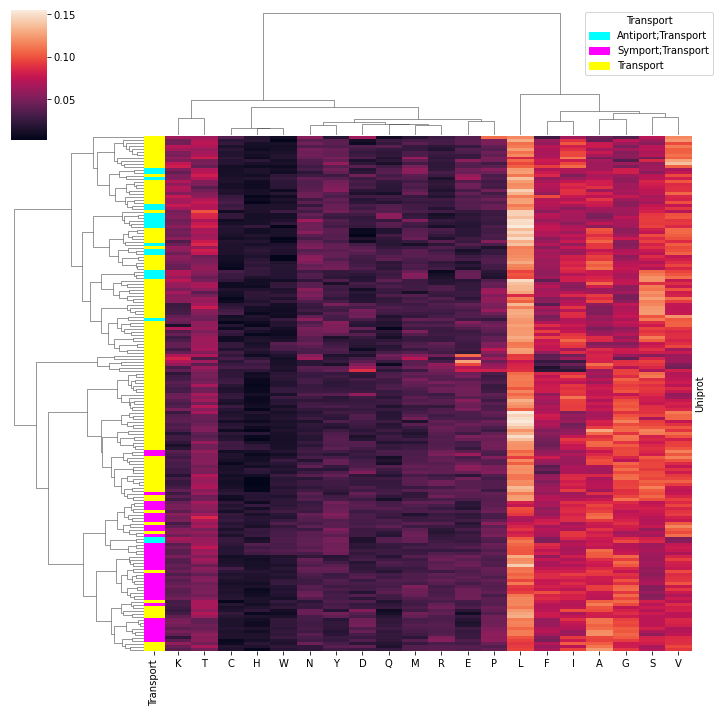

In [21]:
labeled_clustermap(df_aac, df.keywords_transport_related.rename("Transport"), xlabels="auto")

In [22]:
df.loc[clusters[0]].keywords_transport_related.value_counts()

Transport             52
Symport;Transport     39
Antiport;Transport     2
Name: keywords_transport_related, dtype: int64

What are the two antiporters in the symporter cluster?

They are the only two UTR-family proteins in the ER membrane. There are more ER proteins and UTR proteins in the dataset, but UTR/ER proteins seem to have differences regarding the sequence.

In [23]:
df.loc[clusters[0]][df.loc[clusters[0]].keywords_transport_related == "Antiport;Transport"]

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
O64503,Sugar transport,Endoplasmic reticulum;Membrane;Transmembrane,Antiport;Transport,UTR1 At2g02810 T20F6.5,UDP-galactose/UDP-glucose transporter 1 (At-UD...,2.A.7.11.4,2.A,3702,MEVHGSGFRRILLLALCISGIWSAYIYQGVLQETLSTKRFGPDEKR...
Q9M9S6,Sugar transport,Endoplasmic reticulum;Membrane;Transmembrane,Antiport;Transport,UTR3 MSS4 At1g14360 F14L17.13,UDP-galactose/UDP-glucose transporter 3 (AtUTr3),NaN,0.0,3702,MESHGSGLRRVLLLSFCVAGIWAAYIYQGILQETLSTKKFGEDGKR...


({'Endoplasmic reticulum;Membrane;Transmembrane': 'cyan',
  'Membrane;Transmembrane': 'magenta'},
 <seaborn.matrix.ClusterGrid at 0x7f10d8c12130>)

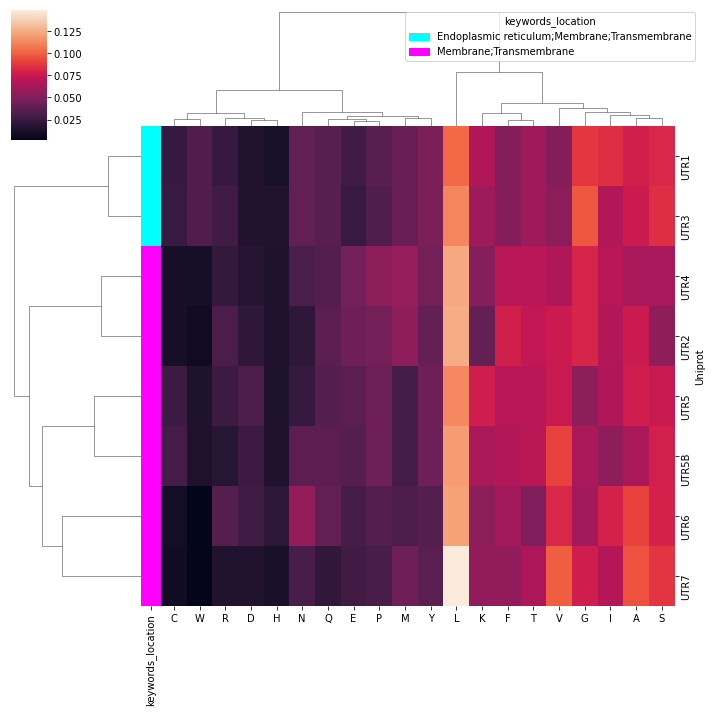

In [24]:
df_utr = df[df.gene_names.str.contains("UTR")]

labeled_clustermap(
    df_aac.loc[df_utr.index],
    df_utr.keywords_location,
    ylabels=df_utr.gene_names.str.split().apply(lambda x: x[0]),
    xlabels="auto",
)

### PAAC plot

The paac feature contains a small subset of frequently occuring dipeptides.

({'Amino-acid transport': 'cyan', 'Sugar transport': 'magenta'},
 <seaborn.matrix.ClusterGrid at 0x7f10c3167280>)

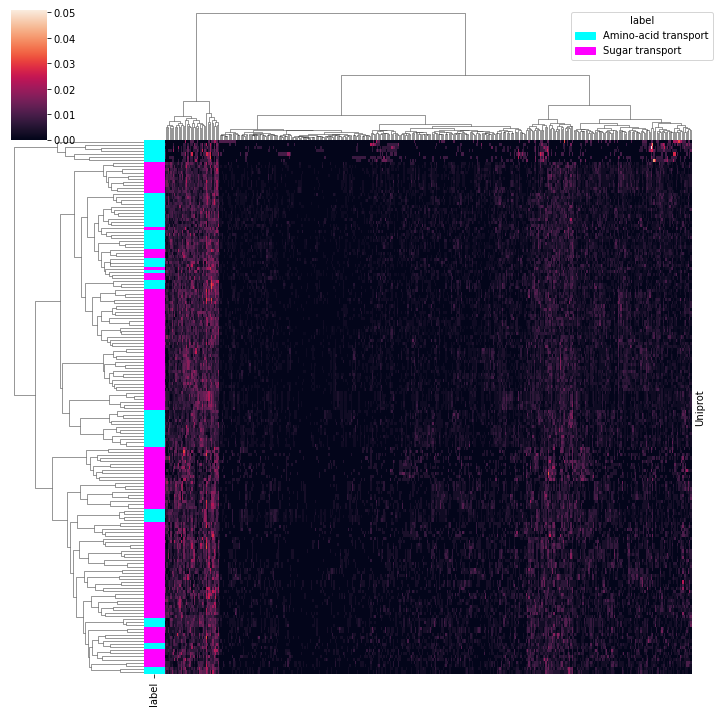

In [25]:
labeled_clustermap(df_paac, labels)

In [26]:
# cluster1 is the smaller one.
cluster0, cluster1 = get_clusters(df_paac.T, n_clusters=2)
print(len(cluster1))
from collections import Counter
counter = Counter()
for dipeptide in cluster1:
    counter[dipeptide[0]] +=1
    counter[dipeptide[1]] +=1
counter

41


Counter({'A': 12, 'G': 14, 'I': 8, 'L': 16, 'S': 14, 'V': 10, 'F': 6, 'T': 2})

### PCA plots

Finally, the PCA plots make it very clear what is going on.

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

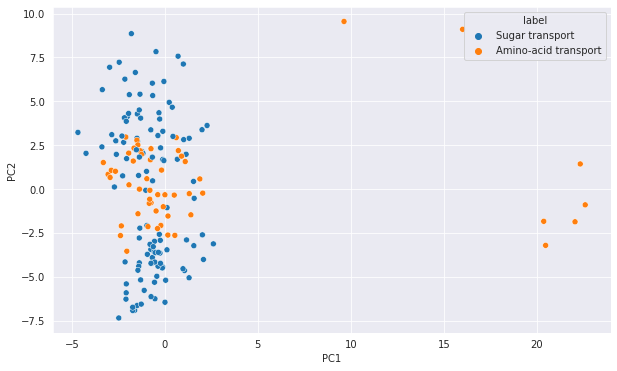

In [27]:
pca_plot_2d(df_paac, labels)

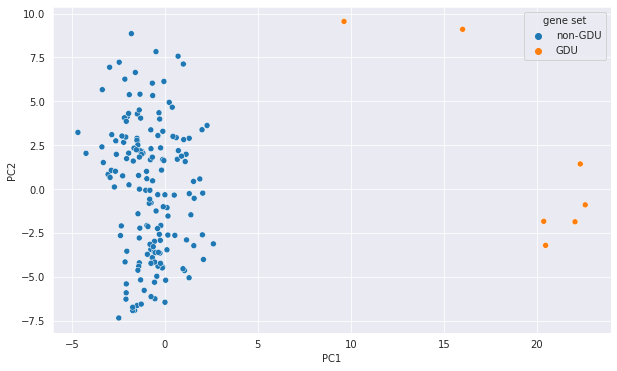

In [28]:
pca_plot_2d(
    df_paac,
    df.gene_names.apply(lambda x: "GDU" if x.startswith("GDU") else "non-GDU").rename(
        "gene set"
    ),
)
# import matplotlib.pyplot as plt
# plt.savefig("athaliana_pca_outliers.png", dpi=300)

<Axes3DSubplot:xlabel='PC1', ylabel='PC2'>

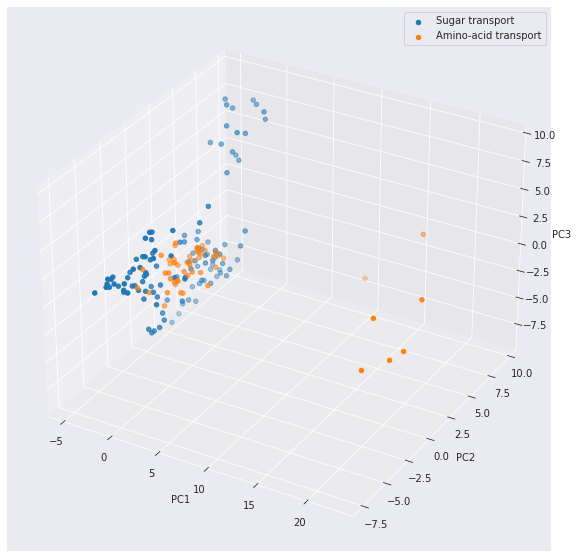

In [29]:
pca_plot_3d(df_paac, labels)

<Axes3DSubplot:xlabel='PC1', ylabel='PC2'>

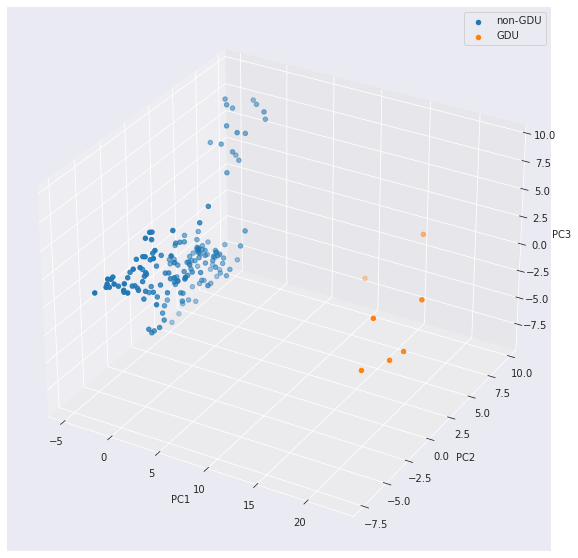

In [30]:
pca_plot_3d(
    df_paac,
    df.gene_names.apply(lambda x: "GDU" if x.startswith("GDU") else "non-GDU").rename(
        "gene set"
    ),
)

## Feature plots



#### Correlation

There do not seem to be any features that show a high correlation across all classes:

<AxesSubplot:>

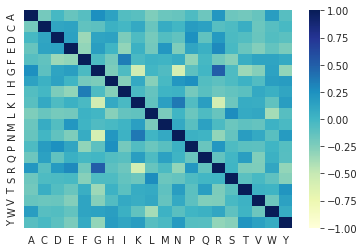

In [31]:
corr_heatmap(df_aac)

<AxesSubplot:>

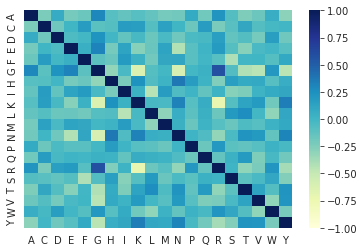

In [32]:
corr_heatmap(df_aac.loc[df[df.keywords_transport == "Sugar transport"].index])

<AxesSubplot:>

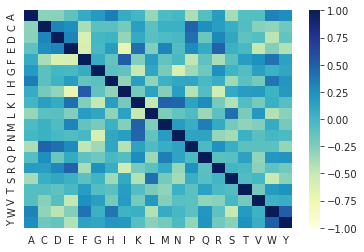

In [33]:
corr_heatmap(df_aac.loc[df[df.keywords_transport == "Amino-acid transport"].index])

#### Distribution

According to shapiro-wilk, most features follow a normal distribution. There is a slight deviation for E and P.

<AxesSubplot:>

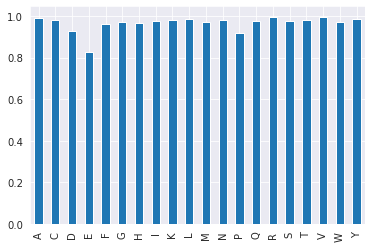

In [34]:
from scipy.stats import shapiro

df_aac.apply(shapiro).loc[0].plot.bar()

##### High Proline

There are two outliers in the dist.

<AxesSubplot:ylabel='Frequency'>

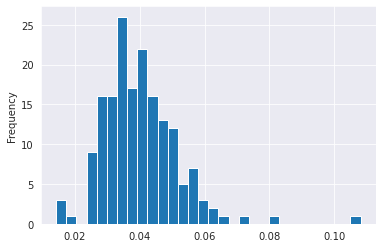

In [35]:
df_aac.P.plot.hist(bins=30)

 Upon further inspection, they are two of the GDU proteins we found earlier.

In [36]:
df.loc[df_aac[df_aac.P > 0.08].index].join(df_aac.P, how="left").drop("sequence", axis=1)

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,P
Uniprot,,,,,,,,,
Q9FHH5,Amino-acid transport,Membrane;Transmembrane,Transport,GDU3 LBS1 At5g57685 MRI1.4,Protein GLUTAMINE DUMPER 3 (Protein LESS SUSCE...,NaN,0.0,3702,0.081081
Q3EAV6,Amino-acid transport,Membrane;Transmembrane,Transport,GDU6 At3g30725 T4A2.7,Protein GLUTAMINE DUMPER 6,NaN,0.0,3702,0.108108


##### High Glutamate

There seem to be more outliers for glutamate

<AxesSubplot:ylabel='Frequency'>

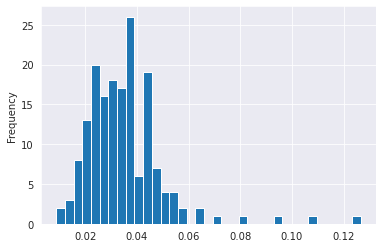

In [37]:
df_aac.E.plot.hist(bins=35)

Again, we find five of the GDU family proteins

In [38]:
df.loc[df_aac[df_aac.E > 0.065].index].join(df_aac.E, how="left").drop("sequence", axis=1)

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,E
Uniprot,,,,,,,,,
O81775,Amino-acid transport,Cell membrane;Membrane;Transmembrane,Transport,GDU1 At4g31730 F28M20.80,Protein GLUTAMINE DUMPER 1,1.A.41.2.2,1.A,3702,0.126582
Q9SW07,Amino-acid transport,Membrane;Transmembrane,Transport,GDU2 At4g25760 F14M19.40,Protein GLUTAMINE DUMPER 2,NaN,0.0,3702,0.069767
Q9FHH5,Amino-acid transport,Membrane;Transmembrane,Transport,GDU3 LBS1 At5g57685 MRI1.4,Protein GLUTAMINE DUMPER 3 (Protein LESS SUSCE...,NaN,0.0,3702,0.081081
Q8S8A0,Amino-acid transport,Membrane;Transmembrane,Transport,GDU4 At2g24762 F27A10.11,Protein GLUTAMINE DUMPER 4,NaN,0.0,3702,0.096154
Q3E965,Amino-acid transport,Membrane;Transmembrane,Transport,GDU5 At5g24920 F6A4.130,Protein GLUTAMINE DUMPER 5,NaN,0.0,3702,0.106870


## Quick evaluation

Does removing the outliers improve the scores? We will only test AAC here, the other features should perform better

### Evaluation without removing outliers

<AxesSubplot:xlabel='label', ylabel='F1 score'>

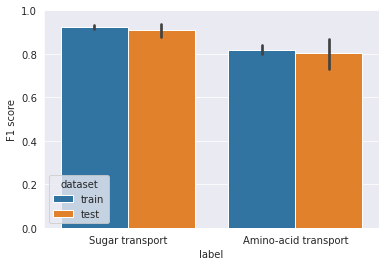

In [39]:
df_scores, _ = full_test(df_aac, labels)
plot_full_test(df_scores)

In [40]:
group = df_scores.groupby(["label", "dataset"])
group.mean().rename({"F1 score": "mean"}, axis=1).join(
    group.std().rename({"F1 score": "std"}, axis=1)
)

mean       std
label                dataset                  
Amino-acid transport test     0.8021  0.124041
                     train    0.8191  0.037998
Sugar transport      test     0.9074  0.052284
                     train    0.9222  0.015361

In [41]:
display(quick_test(df_aac, labels))
models_quick_compare(df_aac, labels)

{'svc__C': 1, 'svc__class_weight': 'balanced', 'svc__gamma': 0.1}
0.879
Default  0.879
{'pca__n_components': 0.91, 'svc__C': 10, 'svc__class_weight': 'balanced', 'svc__gamma': 0.1}
0.826
PCA 0.826
{'selectkbest__k': 19, 'svc__C': 10, 'svc__class_weight': 'balanced', 'svc__gamma': 0.1}
0.854
Kbest 0.854


None

,0,1,2,3,4,mean,std
est,,,,,,,
GaussianNB(),0.757,0.440,0.671,0.701,0.622,0.638,0.121
KNeighborsClassifier(),0.806,0.819,0.788,0.828,0.621,0.772,0.086
"LinearSVC(class_weight='balanced', max_iter=1000000.0)",0.579,0.720,0.689,0.866,0.646,0.700,0.107
LinearSVC(max_iter=1000000.0),0.650,0.626,0.798,0.828,0.671,0.715,0.092
RandomForestClassifier(),0.703,0.618,0.897,0.849,0.550,0.723,0.148
RandomForestClassifier(class_weight='balanced'),0.728,0.703,0.804,0.849,0.615,0.740,0.091
SGDClassifier(),0.694,0.644,0.678,0.671,0.647,0.667,0.021
SVC(),0.703,0.776,0.890,0.849,0.615,0.767,0.111
SVC(class_weight='balanced'),0.898,0.903,0.901,0.967,0.622,0.858,0.135


### Evaluation without outliers

In [42]:
outliers = df[df.gene_names.str.startswith("GDU")]
df_no_outliers = create_dataset(
    keywords_substrate_filter=["Amino-acid transport", "Sugar transport"],
    keywords_component_filter=["Transmembrane"],
    keywords_transport_filter=["Transport"],
    input_file="../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate="keep",
    verbose=True,
    tax_ids_filter=[3702],
    outliers=outliers.index.tolist(),
    output_log="../logs/athaliana_amino_sugar_dataset.log",
)
df_aac_no_outliers=calculate_aac(df_no_outliers.sequence)
labels_no_outliers=df_no_outliers.keywords_transport

Removal of outliers seems to make models more stable. The problems with inconsistent results across CV folds for the balanced SVC are solved.

In [43]:
display(quick_test(df_aac_no_outliers, labels_no_outliers))
models_quick_compare(df_aac_no_outliers, labels_no_outliers)

{'svc__C': 1, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale'}
0.876
Default  0.876
{'pca__n_components': 0.99, 'svc__C': 10, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale'}
0.872
PCA 0.872
{'selectkbest__k': 19, 'svc__C': 1, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale'}
0.884
Kbest 0.884


None

,0,1,2,3,4,mean,std
est,,,,,,,
GaussianNB(),0.802,0.618,0.752,0.802,0.857,0.766,0.091
KNeighborsClassifier(),0.835,0.728,0.752,0.815,0.727,0.772,0.050
"LinearSVC(class_weight='balanced', max_iter=1000000.0)",0.815,0.756,0.771,0.857,0.864,0.812,0.049
LinearSVC(max_iter=1000000.0),0.723,0.785,0.752,0.889,0.857,0.801,0.070
RandomForestClassifier(),0.665,0.694,0.784,0.802,0.728,0.735,0.058
RandomForestClassifier(class_weight='balanced'),0.694,0.618,0.835,0.728,0.637,0.703,0.086
SGDClassifier(),0.752,0.802,0.752,0.889,0.815,0.802,0.056
SVC(),0.694,0.728,0.784,0.889,0.881,0.795,0.088
SVC(class_weight='balanced'),0.924,0.802,0.895,0.932,0.825,0.876,0.059


<AxesSubplot:xlabel='label', ylabel='F1 score'>

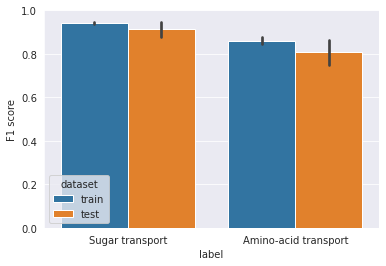

In [44]:
df_scores_no_outliers, _ = full_test(df_aac_no_outliers, labels_no_outliers)
plot_full_test(df_scores_no_outliers)

In [45]:
group = df_scores_no_outliers.groupby(["label", "dataset"])
group.mean().rename({"F1 score": "mean"}, axis=1).join(
    group.std().rename({"F1 score": "std"}, axis=1)
)

mean       std
label                dataset                  
Amino-acid transport test     0.8067  0.100687
                     train    0.8611  0.026660
Sugar transport      test     0.9140  0.057966
                     train    0.9417  0.007288